In [68]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
input_file = 'SimpleTree.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = arrays['Cal_hit_energy']>0
cut_HCAL = (arrays['Cal_hit_energy']>0) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]

xHcal = posx[cut_HCAL]
yHcal = posy[cut_HCAL]
zHcal = posz[cut_HCAL]
eHcal = energy[cut_HCAL]

xEcal = posx[cut_ECAL]
yEcal = posy[cut_ECAL]
zEcal = posz[cut_ECAL]
eEcal = energy[cut_ECAL]

In [12]:
norms = np.sqrt(xcut**2 + ycut**2 + zcut**2)
px = (xcut / norms) * ecut
py = (ycut / norms) * ecut
pz = (zcut / norms) * ecut
ex = np.abs(px)

momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(ecut)
    }
)

allLorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)

print(allLorentz)

[[{px: -0.074, py: -0.187, pz: 1.69, E: 1.7}, ..., {px: 0.0281, ...}], ...]


In [73]:
# Define the jet definition
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)

# Cluster the particles into jets
cluster = fastjet.ClusterSequence(allLorentz, jetdef)
inc_jets = cluster.inclusive_jets()

# Define a function to calculate the x, y, and z components of the momentum vector
def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

# Define a function to calculate the eta coordinate
def eta(y, z):
    theta = abs(np.arctan(y / z))
    return -1 * np.log(np.tan(theta / 2))

def inverse_eta(eta, z):
    y = z * (2 * np.exp(-eta)) / (1 - np.exp(-2*eta))
    return y

def phi(x,y):
    return np.arctan2(y, x)

In [74]:
# Mask the jets based on the energy of their constituents
mask = inc_jets.E > 10
inc_jets_masked = inc_jets[mask]

# Extract the x, y, and z components of the momentum vector
jetX, jetY, jetE = [], [], []
jetXAll, jetYAll, jetEAll, jetEta = [], [], [], []


x, y, z = momentum_xyz(inc_jets_masked.px, inc_jets_masked.py, inc_jets_masked.pz)
    
jetE = inc_jets_masked.E
jetXH = 806 * x / z
jetYH = 806 * y / z

jetXE = 724 * x / z
jetYE = 724 * y / z

jetEta = eta(np.sqrt(x**2 + y**2), z)
jetPhi = phi(x,y)


8.985868789924346
4.464516033919236
3.8513244022668633
3.1461664981485455
3.6726135951782943

5.341294542145601
6.902109323116112
3.9056638114525315
3.307166165988636
4.632169880563237
2.9823675263882397
3.6642481475281734



/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


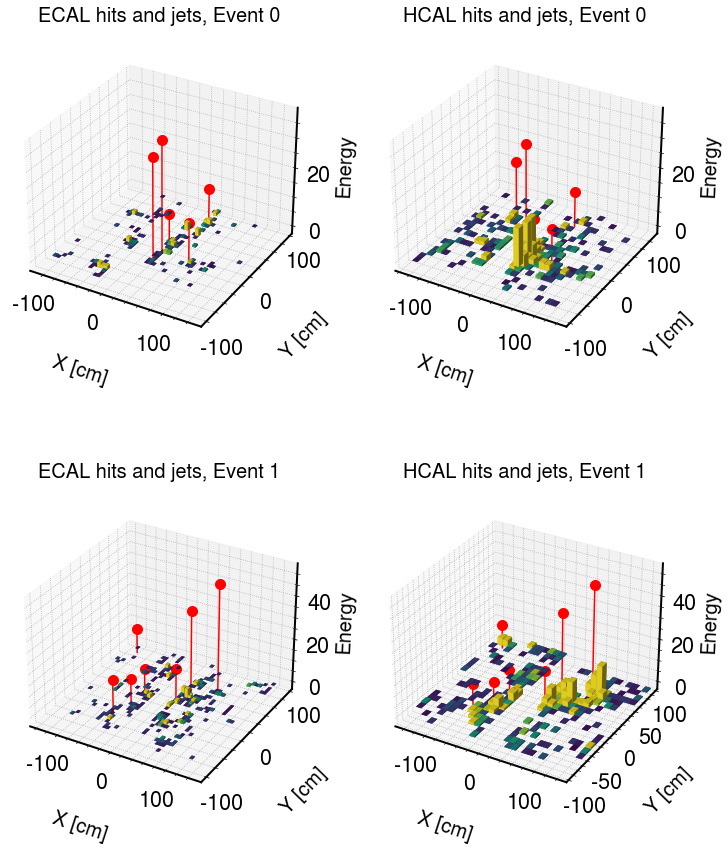

In [54]:
n = 5

fig, axs = plt.subplots(nrows=n, ncols=2, subplot_kw={'projection': '3d'}, figsize=(12, 8*n), gridspec_kw={'hspace': 0.1})

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')

for i in range(n):
    evt = i
    
    ax = axs[i][0]
    ax.set_title(f'ECAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.bar3d(np.array(xEcal[evt]), np.array(yEcal[evt]), 0, 5.5694733, 5.572006, np.array(eEcal[evt]), color=[cmap(k) for k in np.array(eEcal[evt])])

    plt.xlim(-150,150)
    plt.ylim(-100,100)
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXE[evt][j]
        y_pos = jetYE[evt][j]
        z_pos = jetE[evt][j]
        ax.scatter(x_pos, y_pos, z_pos, s=100, color='red', marker='o')
        ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, z_pos], color='red')

    
    ax = axs[i][1]
    ax.set_title(f'HCAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.bar3d(np.array(xHcal[evt]), np.array(yHcal[evt]), 0, 9.985443, 9.98999, np.array(eHcal[evt]), color=[cmap(k) for k in np.array(eHcal[evt])])

    plt.xlim(-150,150)
    plt.ylim(-100,100)
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXH[evt][j]
        y_pos = jetYH[evt][j]
        z_pos = jetE[evt][j]
        ax.scatter(x_pos, y_pos, z_pos, s=100, color='red', marker='o')
        ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, z_pos], color='red')

plt.tight_layout()



0.0066395039618190165
0.5704848082508236
0.36360053812524434
1.0595271002233804
1.0890453283606853

0.2611501926784604
0.056404318162144515
0.7943758743610427
0.9849733749094782
0.3188658889780413
0.6242157106861794
0.47341683964376763



/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


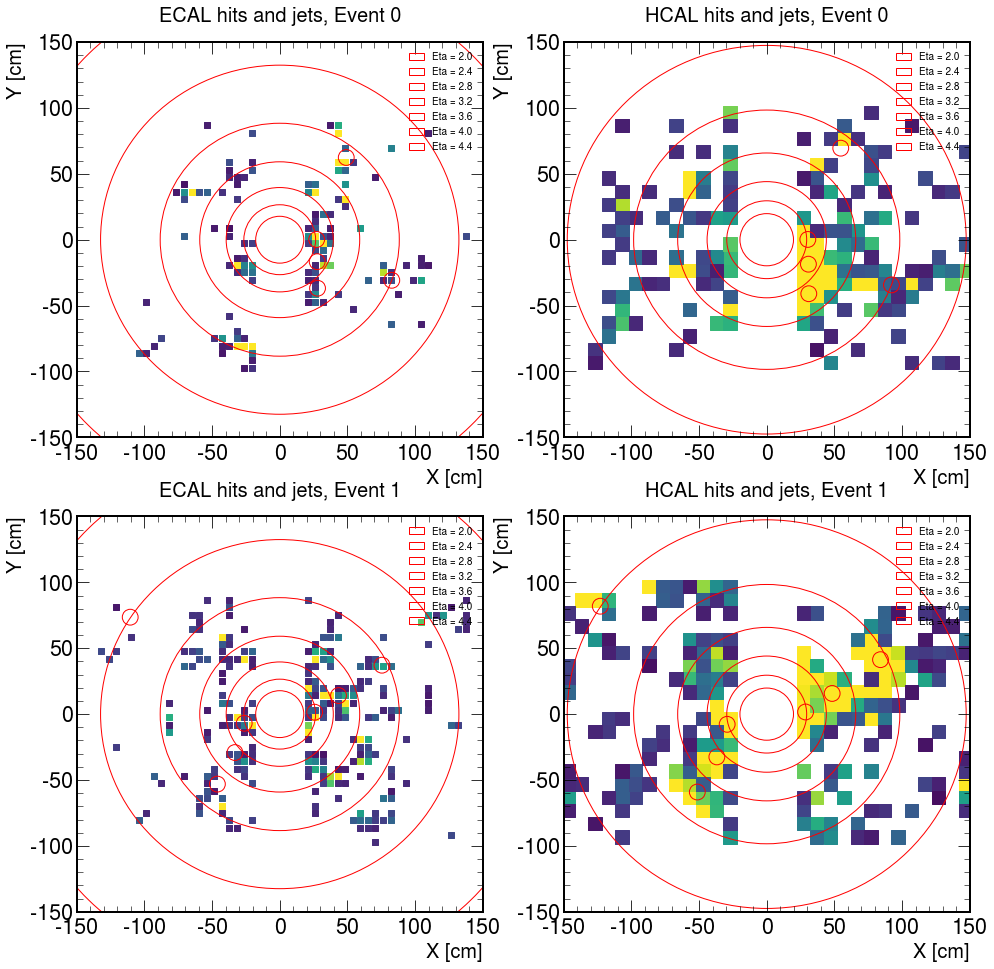

In [60]:
from matplotlib.patches import Circle

n = 2

fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(16, 8*n), gridspec_kw={'hspace': 0.2})

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')

for i in range(n):
    evt = i
    
    ax = axs[i][0]
    ax.set_title(f'ECAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.scatter(np.array(xEcal[evt]), np.array(yEcal[evt]), marker = 's', color=[cmap(k) for k in np.array(eEcal[evt])])

    

    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)


    for j in range(20, 48, 4):
        j = j / 10.0
        R = inverse_eta(j,724)
        color = ((1 - (j-2))/2, 0, (j-2)/2)
        circle = Circle((0, 0), R, color='r', fill=False, label = f'Eta = {j}')
        axs[i,0].add_patch(circle)  
   
    handles, labels = axs[i,0].get_legend_handles_labels()

    
    axs[i,0].legend(handles, labels, loc='upper right',fontsize=10)
 
    axs[i,0].set_ylim(-150,150)
    axs[i,0].set_xlim(-150,150)
    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXE[evt][j]
        y_pos = jetYE[evt][j]

        ax.scatter(x_pos, y_pos, s=250, facecolors='none', edgecolors='r')

    
    
    ax = axs[i][1]
    ax.set_title(f'HCAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.scatter(np.array(xHcal[evt]), np.array(yHcal[evt]), s=180, marker='s', color=[cmap(k) for k in np.array(eHcal[evt])])

    axs[i,1].set_ylim(-150,150)
    axs[i,1].set_xlim(-150,150)
    
    for j in range(20, 48, 4):
        j = j / 10.0
        R = inverse_eta(j,806)
        color = ((1 - (j-2))/2, 0, (j-2)/2)
        circle = Circle((0, 0), R, color='r', fill=False, label = f'Eta = {j}')
        axs[i,1].add_patch(circle) 
   
    handles, labels = axs[i,1].get_legend_handles_labels()

    axs[i,1].legend(handles, labels, loc='upper right', fontsize=10)

    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXH[evt][j]
        y_pos = jetYH[evt][j]
        ax.scatter(x_pos, y_pos, s=250, facecolors='none', edgecolors='r')

plt.tight_layout()



Text(0.5, 1.0, 'Jet Multiplicity')

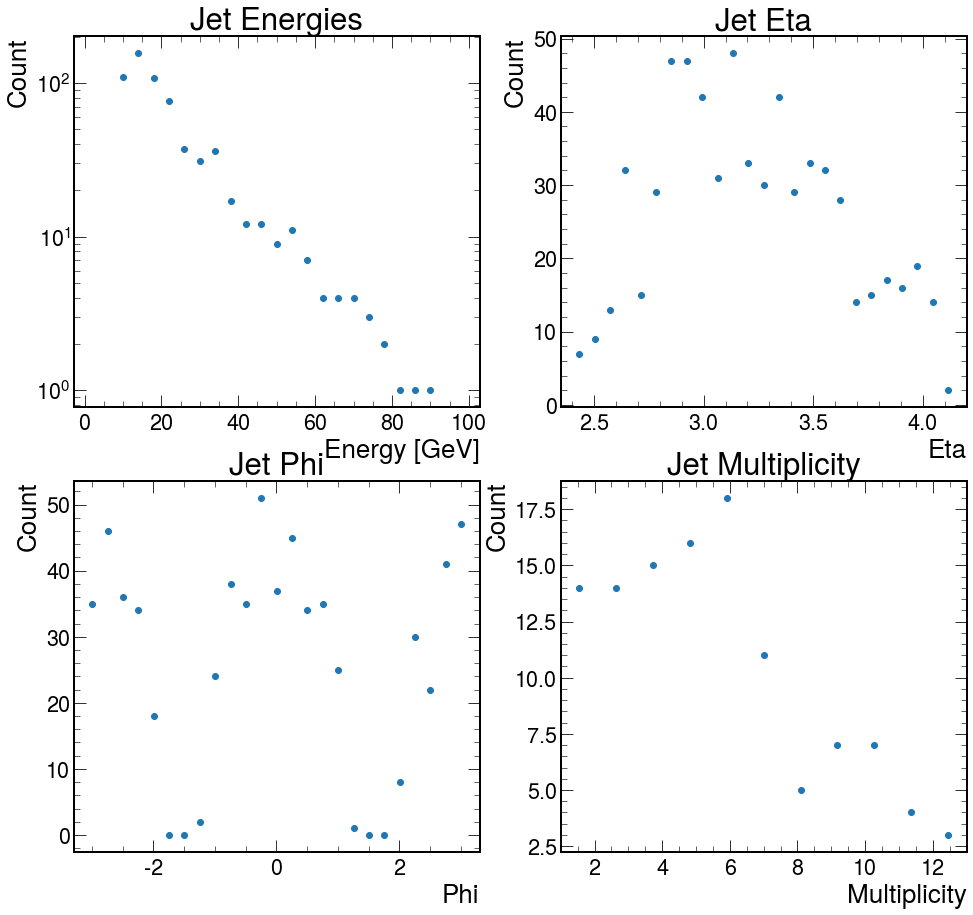

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.2})


plt.sca(axs[0][0])
ax.set_title("Jet Energies", fontsize=20, pad=20)

hist, bin_edges = np.histogram(ak.flatten(jetE),range=(0,100),bins=round(np.sqrt(len(ak.flatten(jetE)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)
plt.yscale("log")
plt.xlabel('Energy [GeV]')
plt.ylabel('Count')
plt.title("Jet Energies")

plt.sca(axs[0][1])
ax.set_title("Jet Eta", fontsize=20, pad=20)

hist, bin_edges = np.histogram(ak.flatten(jetEta),bins=round(np.sqrt(len(ak.flatten(jetEta)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)

plt.xlabel('Eta')
plt.ylabel('Count')
plt.title("Jet Eta")


plt.sca(axs[1][0])


hist, bin_edges = np.histogram(ak.flatten(jetPhi),bins=round(np.sqrt(len(ak.flatten(jetPhi)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)

plt.xlabel('Phi')
plt.ylabel('Count')
plt.title("Jet Phi")

def get_multiplicity(data):
    return ak.Array([len(subarray) for subarray in data])

plt.sca(axs[1][1])


hist, bin_edges = np.histogram(get_multiplicity(jetE),bins=round(np.sqrt(len(get_multiplicity(jetE)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)

plt.xlabel('Multiplicity')
plt.ylabel('Count')
plt.title("Jet Multiplicity")
